# Detection of middle ear events in Tinnitus patients polysomnographic data


In [1]:
#Only once when launching notebook
import os
PATH = os.getcwd() 
import sys
sys.path.append(PATH + '/../')

%matplotlib widget
import matplotlib.pyplot as plt
from time import time
print("Config loaded")

Config loaded


## Load, filter, and prepare data

In [2]:
import mne
from tinnsleep.config import Config
from tinnsleep.data import CreateRaw
import pandas as pd
data_info = pd.read_csv("data/data_info.csv",engine='python', sep=";")

filename = Config.bruxisme_files[36]  # load file from config
mema_files = data_info[data_info["mema"]==1]['filename'].values
assert filename.split(os.path.sep)[-1] in mema_files, f"MEMA not available for {filename.split(os.path.sep)[-1]}"
picks_chan = ['Airflow']           # subset of EMG electrodes
ch_types = ["misc"]

start = time()

raw  = mne.io.read_raw_edf(filename, preload=False)  # prepare loading
tmin = raw.times[0]                     
tmax = raw.times[-1]
raw  = CreateRaw(raw[picks_chan][0], raw.info["sfreq"], picks_chan, ch_types=ch_types)        # pick channels and load

raw  = raw.filter(0.1, 5., n_jobs=4, 
                  fir_design='firwin', filter_length='auto', phase='zero-double',
                  picks=['Airflow'])
ch_names = raw.info["ch_names"]
print(f"Data filtered ({time()-start:.2f}s)")
offset = raw.times[0]
print(f"keeping {(raw.times[-1]-raw.times[0])/3600:0.2f} hours of recording out of {(tmax-tmin)/3600:0.2f} hours")

Extracting EDF parameters from /Users/louis/Data/SIOPI/bruxisme/1SL21_nuit_3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-2-752897fb1f7b>:15: RuntimeWarning: 7 channel names are too long, have been truncated to 15 characters:
['Inductance Abdom', 'Inductance Thora', 'Intensit? lumine', 'Jambe droite Imp', 'Jambe gauche Imp', 'Tension (aliment', 'Tension (Bluetoo']
  raw  = mne.io.read_raw_edf(filename, preload=False)  # prepare loading


Data filtered (3.49s)
keeping 10.02 hours of recording out of 10.02 hours


## Epoching data

In [3]:
from tinnsleep.data import RawToEpochs_sliding
start = time()
sfreq = raw.info["sfreq"]
window_length = 1                    # in seconds
duration = int(window_length * sfreq)   # in samples
interval = duration                     # no overlapping
epochs = RawToEpochs_sliding(raw, duration=duration, interval=interval)
print(f"Epochs done, shape {epochs.shape} in {time()-start:.2f}s")


Epochs done, shape (36070, 1, 250) in 0.16s


## Classifying epochs and annotate raw

In [4]:
from tinnsleep.classification import AmplitudeThresholding
from tinnsleep.signal import rms
from tinnsleep.data import CleanAnnotations, AnnotateRaw_sliding
from tinnsleep.events.scoring import classif_to_burst, burst_to_episode, episodes_to_list

import numpy as np

start = time()
length_adaptive = 60 # in seconds
rel_THR= 3.5
max_duration_between_bursts = 3

#-----------------MEMA processing Foward-backward ---------------------------------------
#Foward
# compute the sum of power over electrodes and samples in each window
pipeline = AmplitudeThresholding(abs_threshold=0., rel_threshold=rel_THR, n_adaptive=length_adaptive)
X        = rms(epochs) # take only valid labels
labels_f   = pipeline.fit_predict(X)


#Backward
#Reversing epochs array
epochs = epochs[::-1]
 # compute the sum of power over electrodes and samples in each window
pipeline = AmplitudeThresholding(abs_threshold=0., rel_threshold=rel_THR, n_adaptive=length_adaptive)
X        = rms(epochs) # take only valid labels
labels   = pipeline.fit_predict(X)
#Reversing labels
labels_b = labels[::-1]


#-----------------MEMA foward-backward merge ---------------------------------------
# Logical OR -- merged backward and foward
labels_fb = np.any(np.c_[labels_f, labels_b], axis=-1)


#-----------------MEMA bursts conversion to episodes ----------------------------------------
list_bursts = classif_to_burst(labels_fb, time_interval=window_length)
list_episodes = burst_to_episode(list_bursts, delim=max_duration_between_bursts, min_burst_joining=0)
list_labels = episodes_to_list(list_episodes, window_length,len(labels_fb))

print(np.unique(list_labels))
#All episodes as tonic
for i in range(len(list_labels)):
    if list_labels[i]!=0:
        list_labels[i]=True
    else:
        list_labels[i] = False


print(f"bursts count: {np.sum(list_labels)}/{len(list_labels)} ({np.sum(list_labels) / len(list_labels) * 100:.2f}%)")
print(f"bursts time: {np.sum(list_labels) * window_length} seconds")
print(f"Classification done in {time()-start:.2f}s")

start = time()
dict_annotations = {1: "MEA"}

[  0. 101. 111. 121. 131. 141. 151.]
bursts count: 1039.0/36070 (2.88%)
bursts time: 1039.0 seconds
Classification done in 8.02s


In [5]:
raw = CleanAnnotations(raw)
raw = AnnotateRaw_sliding(raw, list_labels, 
                dict_annotations=dict_annotations, duration=duration, interval=interval, merge=True)
print(f"Raw annotated in {time()-start:.2f}s")

Raw annotated in 0.05s


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

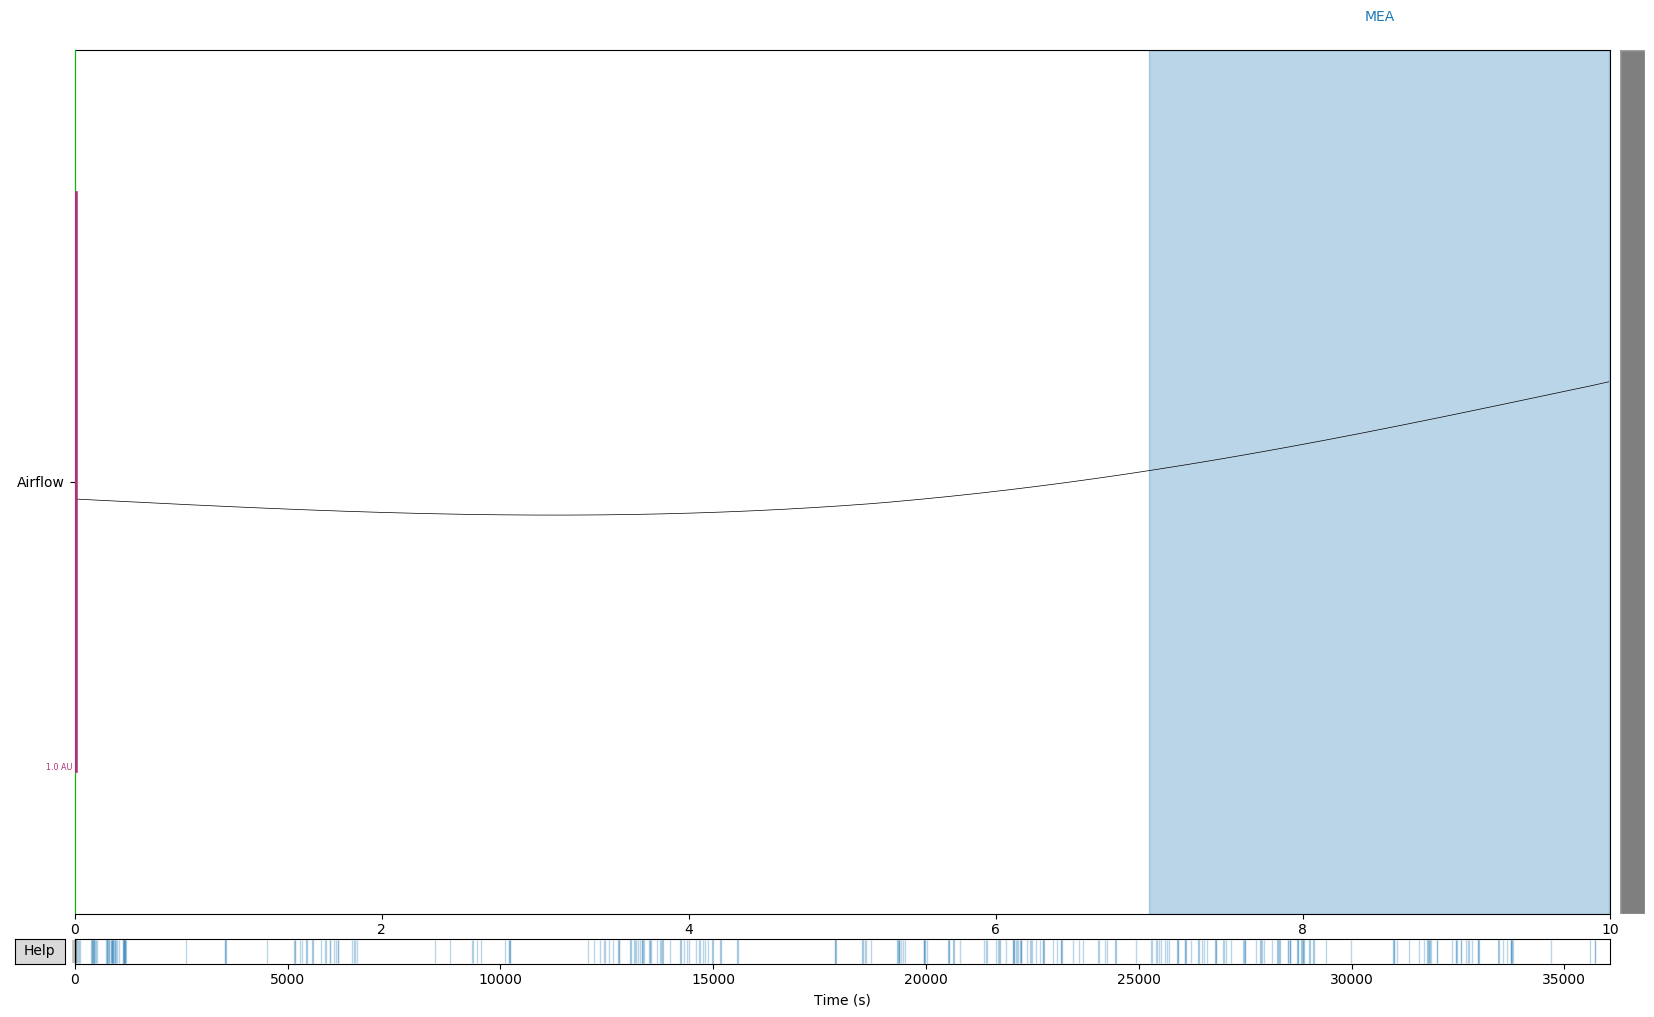

In [6]:
scalings = dict(misc=0.5)
raw.plot(scalings = scalings)